In [1]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 2.2.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.0.3, but you have pandas 2.2.2 which is incompatible.


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import AddMissingIndicator

In [24]:
boston_dataset = pd.read_csv('boston.csv')

<ipython-input-25-4dbfcba3aed3>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(boston_dataset['RM'], bins=30)


<Axes: xlabel='RM', ylabel='Density'>

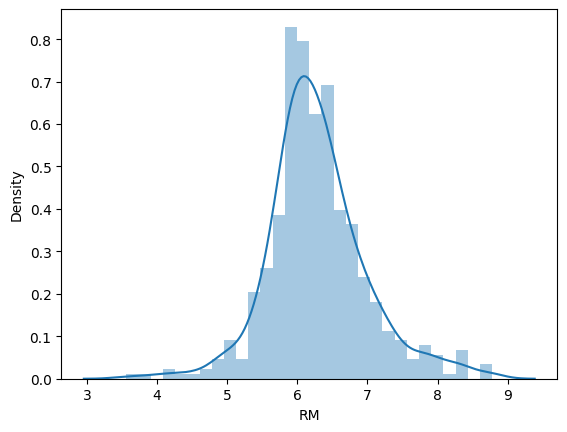

In [25]:
sns.distplot(boston_dataset['RM'], bins=30)

In [17]:
def find_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

In [26]:
RM_upper_limit, RM_lower_limit = find_boundaries(boston, 'RM', 1.5)
print(RM_upper_limit, RM_lower_limit )

#ตัวแปรไหนที่มีค่าเกิน 7.73 หรือน้อยกว่า 4.77 จะเป็น Outlier

7.730500000000001 4.778499999999999


In [28]:
outliers_RM = np.where(boston_dataset['RM'] > RM_upper_limit, True, np.where(boston['RM'] < RM_lower_limit,
True, False))

In [29]:
outliers_RM

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [30]:
# จะดูเฉพาะ Outlier โดยการตัดมันออกไปจาก Data
boston_trimmed = boston.loc[~(outliers_RM)]

In [31]:
def winsorize(df, variable, upper_limit, lower_limit):
    return np.where(df[variable] > upper_limit, upper_limit, np.where(df[variable] < lower_limit, lower_limit, df[variable]))

In [32]:
boston['RM'] = winsorize(boston, 'RM', boston['RM'].quantile(0.95), boston['RM'].quantile(0.05))

In [33]:
boston_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [34]:
from feature_engine.outliers import Winsorizer

In [35]:
# หา Outlier ด้วยการใช้ Quantiles
# ตัดทั้งหัวทั้งท้ายเลย
# ตัวแปรที่เราต้องการหา Outlier
windsorizer = Winsorizer(capping_method='quantiles', tail='both', variables=['LSTAT'], fold=0.05)

In [36]:
windsorizer.fit(boston)
boston_t = windsorizer.transform(boston)

In [37]:
#ตัดทางซ้ายที่เท่าไร
windsorizer.left_tail_caps_

{'LSTAT': 3.7075}

In [38]:
#ตัดทางขวาที่เท่าไร
windsorizer.right_tail_caps_

{'LSTAT': 26.8075}

In [39]:
windsorizer = Winsorizer(capping_method='gaussian', tail='both', fold=3, variables=['CRIM'])
windsorizer.fit(boston)
boston_t = windsorizer.transform(boston_t)

In [40]:
print(windsorizer.left_tail_caps_)
print(windsorizer.right_tail_caps_)

{'CRIM': -22.16560049657506}
{'CRIM': 29.392647611199564}
